# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="anferico/bert-for-patents"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=256
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0,1,2,3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from torch.autograd.function import InplaceFunction
import torch.nn.init as init
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.9.1
Found existing installation: transformers 4.16.2
Uninstalling transformers-4.16.2:
  Successfully uninstalled transformers-4.16.2


Found existing installation: tokenizers 0.11.6
Uninstalling tokenizers-0.11.6:
  Successfully uninstalled tokenizers-0.11.6


Looking in links: ../input/pppm-pip-wheels
Processing /kaggle/input/pppm-pip-wheels/transformers-4.18.0-py3-none-any.whl
Processing /kaggle/input/pppm-pip-wheels/tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.1 requires transformers<4.17,>=4.1, but you have transformers 4.18.0 which is incompatible.


Looking in links: ../input/pppm-pip-wheels


tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
def get_cpc_texts():
    """
    Fix as provided by Nicholas Broad 
    https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/discussion/324928#1790476
    """
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {} 
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
            with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
                s = f.read()
            pattern = f'{cpc}\t\t.+'
            result = re.findall(pattern, s)
            pattern = "^"+pattern[:-2]
            cpc_result = re.sub(pattern, "", result[0])
            for context in [c for c in contexts if c[0] == cpc]:
                pattern = f'{context}\t\t.+'
                result = re.findall(pattern, s)
                pattern = "^"+pattern[:-2]
                results[context] = cpc_result + ". " + re.sub(pattern, "", result[0])
    return results

cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

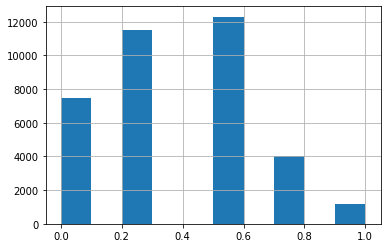

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/322k [00:00<?, ?B/s]

# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 115


In [15]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [16]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [17]:
class Mixout(InplaceFunction):
    @staticmethod
    def _make_noise(input):
        return input.new().resize_as_(input)

    @classmethod
    def forward(cls, ctx, input, target=None, p=0.0, training=False, inplace=False):
        if p < 0 or p > 1:
            raise ValueError("A mix probability of mixout has to be between 0 and 1," " but got {}".format(p))
        if target is not None and input.size() != target.size():
            raise ValueError(
                "A target tensor size must match with a input tensor size {},"
                " but got {}".format(input.size(), target.size())
            )
        ctx.p = p
        ctx.training = training

        if ctx.p == 0 or not ctx.training:
            return input

        if target is None:
            target = cls._make_noise(input)
            target.fill_(0)
        target = target.to(input.device)

        if inplace:
            ctx.mark_dirty(input)
            output = input
        else:
            output = input.clone()

        ctx.noise = cls._make_noise(input)
        if len(ctx.noise.size()) == 1:
            ctx.noise.bernoulli_(1 - ctx.p)
        else:
            ctx.noise[0].bernoulli_(1 - ctx.p)
            ctx.noise = ctx.noise[0].repeat(input.size()[0], 1)
        ctx.noise.expand_as(input)

        if ctx.p == 1:
            output = target
        else:
            output = ((1 - ctx.noise) * target + ctx.noise * output - ctx.p * target) / (1 - ctx.p)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        if ctx.p > 0 and ctx.training:
            return grad_output * ctx.noise, None, None, None, None
        else:
            return grad_output, None, None, None, None


def mixout(input, target=None, p=0.0, training=False, inplace=False):
    return Mixout.apply(input, target, p, training, inplace)


class MixLinear(torch.nn.Module):
    __constants__ = ["bias", "in_features", "out_features"]
    def __init__(self, in_features, out_features, bias=True, target=None, p=0.0):
        super(MixLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()
        self.target = target
        self.p = p

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return F.linear(input, mixout(self.weight, self.target, self.p, self.training), self.bias)

    def extra_repr(self):
        type = "drop" if self.target is None else "mix"
        return "{}={}, in_features={}, out_features={}, bias={}".format(
            type + "out", self.p, self.in_features, self.out_features, self.bias is not None
        )

def replace_mixout(model):
    for sup_module in model.modules():
        for name, module in sup_module.named_children():
            if isinstance(module, nn.Dropout):
                module.p = 0.0
            if isinstance(module, nn.Linear):
                target_state_dict = module.state_dict()
                bias = True if module.bias is not None else False
                new_module = MixLinear(
                    module.in_features, module.out_features, bias, target_state_dict["weight"], 0.5
                )
                new_module.load_state_dict(target_state_dict)
                setattr(sup_module, name, new_module)
    return model

In [18]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()

        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [19]:
class AttentionPool(nn.Module):
    def __init__(self, in_dim):
        super().__init__()

        self.attention = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, 1),
        )

    def forward(self, x, mask):
        w = self.attention(x).float() #
        w[mask==0]=float('-inf')
        w = torch.softmax(w,1)
        x = torch.sum(w * x, dim=1)
        return x

In [20]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.feature_extractor = AutoModelForTokenClassification.from_pretrained(CFG.model)
        in_features = self.feature_extractor.classifier.in_features
        self.attention = TransformerHead(in_features=in_features, max_length=115, num_layers=1, nhead=8, num_targets=1)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
        self._init_weights(self.fc)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        feature = self.attention(last_hidden_states)
        
        return feature


    def forward(self, inputs):
        feature = self.feature(inputs)
        '''
        #print(feature.shape)
        output = torch.mean(
            torch.stack(
                [self.fc(self.fc_dropout(feature)) for _ in range(5)],
                dim=0,),
            dim=0,
        )
        '''
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, reduction='none', alpha=1, gamma=2):
        super().__init__()
        self.reduction = reduction
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1. - pt)**self.gamma * bce_loss
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss


class SmoothFocalLoss(nn.Module):
    def __init__(self, reduction='mean', alpha=1, gamma=2, smoothing=0.1):
        super().__init__()
        self.reduction = reduction
        self.focal_loss = FocalLoss(reduction='none', alpha=alpha, gamma=gamma)
        self.smoothing = smoothing

    @staticmethod
    def _smooth(targets:torch.Tensor, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothFocalLoss._smooth(targets, self.smoothing)
        loss = self.focal_loss(inputs, targets)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss

In [22]:
from torch.nn.modules.loss import _WeightedLoss

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight = None, reduction = 'mean', smoothing = 0.1, pos_weight = None):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction
        self.pos_weight = pos_weight

    @staticmethod
    def _smooth(targets, n_labels, smoothing = 0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad(): targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1), self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight, pos_weight = self.pos_weight)
        if  self.reduction == 'sum': loss = loss.sum()
        elif  self.reduction == 'mean': loss = loss.mean()
        return loss

In [23]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [24]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    model=replace_mixout(model)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = SmoothBCEwLogits() #nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [25]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertForTokenClass

Epoch: [1][0/1693] Elapsed 0m 2s (remain 74m 43s) Loss: 0.6895(0.6895) Grad: 49122.4844  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 44s (remain 27m 19s) Loss: 0.6176(0.6627) Grad: 176695.2969  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 3m 25s (remain 25m 23s) Loss: 0.6528(0.6539) Grad: 85913.0547  LR: 0.00001996  
Epoch: [1][300/1693] Elapsed 5m 6s (remain 23m 37s) Loss: 0.6278(0.6431) Grad: 99501.4375  LR: 0.00001990  
Epoch: [1][400/1693] Elapsed 6m 47s (remain 21m 52s) Loss: 0.5884(0.6364) Grad: 132345.8125  LR: 0.00001983  
Epoch: [1][500/1693] Elapsed 8m 29s (remain 20m 11s) Loss: 0.5885(0.6285) Grad: 83545.8750  LR: 0.00001973  
Epoch: [1][600/1693] Elapsed 10m 10s (remain 18m 29s) Loss: 0.5445(0.6226) Grad: 111887.0234  LR: 0.00001961  
Epoch: [1][700/1693] Elapsed 11m 51s (remain 16m 47s) Loss: 0.6129(0.6177) Grad: 113059.8828  LR: 0.00001948  
Epoch: [1][800/1693] Elapsed 13m 32s (remain 15m 5s) Loss: 0.6875(0.6138) Grad: 184449.2812  LR: 0.00001932  
Epoch: [1][900/1

Epoch 1 - avg_train_loss: 0.5960  avg_val_loss: 0.5815  time: 1848s
Epoch 1 - Score: 0.8133
Epoch 1 - Save Best Score: 0.8133 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 39m 38s) Loss: 0.5392(0.5392) Grad: 75098.1172  LR: 0.00001707  
Epoch: [2][100/1693] Elapsed 1m 42s (remain 26m 59s) Loss: 0.5433(0.5689) Grad: 36793.7656  LR: 0.00001673  
Epoch: [2][200/1693] Elapsed 3m 24s (remain 25m 16s) Loss: 0.4688(0.5647) Grad: 84570.0625  LR: 0.00001638  
Epoch: [2][300/1693] Elapsed 5m 5s (remain 23m 32s) Loss: 0.5131(0.5612) Grad: 84844.8125  LR: 0.00001602  
Epoch: [2][400/1693] Elapsed 6m 46s (remain 21m 49s) Loss: 0.5926(0.5612) Grad: 58072.7734  LR: 0.00001564  
Epoch: [2][500/1693] Elapsed 8m 27s (remain 20m 7s) Loss: 0.6375(0.5615) Grad: 94499.8984  LR: 0.00001525  
Epoch: [2][600/1693] Elapsed 10m 8s (remain 18m 25s) Loss: 0.5890(0.5620) Grad: 108760.3203  LR: 0.00001485  
Epoch: [2][700/1693] Elapsed 11m 49s (remain 16m 44s) Loss: 0.6809(0.5605) Grad: 95609.4688  LR: 0.00001444  
Epoch: [2][800/1693] Elapsed 13m 30s (remain 15m 2s) Loss: 0.5084(0.5607) Grad: 84638.0156  LR: 0.00001402  
Epoch: [2][900/1693] E

Epoch 2 - avg_train_loss: 0.5615  avg_val_loss: 0.5792  time: 1847s
Epoch 2 - Score: 0.8252
Epoch 2 - Save Best Score: 0.8252 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 40m 46s) Loss: 0.6161(0.6161) Grad: 87283.2578  LR: 0.00001000  
Epoch: [3][100/1693] Elapsed 1m 42s (remain 26m 57s) Loss: 0.5386(0.5486) Grad: 41650.7969  LR: 0.00000953  
Epoch: [3][200/1693] Elapsed 3m 23s (remain 25m 12s) Loss: 0.4863(0.5476) Grad: 31358.6367  LR: 0.00000907  
Epoch: [3][300/1693] Elapsed 5m 4s (remain 23m 29s) Loss: 0.6111(0.5467) Grad: 54248.0078  LR: 0.00000861  
Epoch: [3][400/1693] Elapsed 6m 45s (remain 21m 48s) Loss: 0.5957(0.5474) Grad: 78540.7031  LR: 0.00000815  
Epoch: [3][500/1693] Elapsed 8m 27s (remain 20m 6s) Loss: 0.5423(0.5483) Grad: 45754.9023  LR: 0.00000770  
Epoch: [3][600/1693] Elapsed 10m 8s (remain 18m 25s) Loss: 0.5362(0.5489) Grad: 67497.1016  LR: 0.00000725  
Epoch: [3][700/1693] Elapsed 11m 49s (remain 16m 43s) Loss: 0.5823(0.5484) Grad: 45893.4492  LR: 0.00000681  
Epoch: [3][800/1693] Elapsed 13m 30s (remain 15m 2s) Loss: 0.4631(0.5476) Grad: 33151.4180  LR: 0.00000637  
Epoch: [3][900/1693] El

Epoch 3 - avg_train_loss: 0.5464  avg_val_loss: 0.5824  time: 1847s
Epoch 3 - Score: 0.8221


Epoch: [4][0/1693] Elapsed 0m 1s (remain 37m 50s) Loss: 0.5941(0.5941) Grad: 15979.0918  LR: 0.00000293  
Epoch: [4][100/1693] Elapsed 1m 42s (remain 26m 54s) Loss: 0.5335(0.5487) Grad: 32743.3398  LR: 0.00000261  
Epoch: [4][200/1693] Elapsed 3m 23s (remain 25m 10s) Loss: 0.4893(0.5456) Grad: 49992.8828  LR: 0.00000230  
Epoch: [4][300/1693] Elapsed 5m 4s (remain 23m 28s) Loss: 0.5340(0.5422) Grad: 27147.6641  LR: 0.00000202  
Epoch: [4][400/1693] Elapsed 6m 45s (remain 21m 47s) Loss: 0.5623(0.5412) Grad: 25052.4844  LR: 0.00000175  
Epoch: [4][500/1693] Elapsed 8m 26s (remain 20m 5s) Loss: 0.5878(0.5413) Grad: 74141.5938  LR: 0.00000149  
Epoch: [4][600/1693] Elapsed 10m 8s (remain 18m 24s) Loss: 0.5416(0.5403) Grad: 21086.8145  LR: 0.00000126  
Epoch: [4][700/1693] Elapsed 11m 49s (remain 16m 43s) Loss: 0.5934(0.5408) Grad: 65645.7969  LR: 0.00000104  
Epoch: [4][800/1693] Elapsed 13m 30s (remain 15m 2s) Loss: 0.5136(0.5403) Grad: 40342.3242  LR: 0.00000085  
Epoch: [4][900/1693] El

Epoch 4 - avg_train_loss: 0.5399  avg_val_loss: 0.5824  time: 1847s
Epoch 4 - Score: 0.8211
========== fold: 0 result ==========
Score: 0.8252
========== fold: 1 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenc

Epoch: [1][0/1725] Elapsed 0m 1s (remain 38m 40s) Loss: 0.7259(0.7259) Grad: 158626.4219  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 42s (remain 27m 29s) Loss: 0.6732(0.6638) Grad: 64668.1445  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 3m 23s (remain 25m 43s) Loss: 0.5992(0.6456) Grad: 15631.9307  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 5m 5s (remain 24m 4s) Loss: 0.5479(0.6320) Grad: 25114.6328  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 6m 46s (remain 22m 22s) Loss: 0.5945(0.6238) Grad: 19354.4082  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 8m 27s (remain 20m 40s) Loss: 0.5158(0.6172) Grad: 19463.9180  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 10m 8s (remain 18m 58s) Loss: 0.5764(0.6121) Grad: 23549.0098  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 11m 50s (remain 17m 17s) Loss: 0.5963(0.6086) Grad: 8053.8564  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 13m 31s (remain 15m 36s) Loss: 0.5255(0.6057) Grad: 19055.2012  LR: 0.00001934  
Epoch: [1][900/1725] E

Epoch 1 - avg_train_loss: 0.5919  avg_val_loss: 0.5823  time: 1874s
Epoch 1 - Score: 0.8076
Epoch 1 - Save Best Score: 0.8076 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 42m 21s) Loss: 0.5389(0.5389) Grad: 57342.9805  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 42s (remain 27m 32s) Loss: 0.5571(0.5673) Grad: 30731.2930  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 3m 23s (remain 25m 45s) Loss: 0.6358(0.5634) Grad: 62356.3750  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 5m 4s (remain 24m 2s) Loss: 0.5219(0.5606) Grad: 36049.7891  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 6m 46s (remain 22m 20s) Loss: 0.5563(0.5598) Grad: 82590.0469  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 8m 27s (remain 20m 39s) Loss: 0.5824(0.5593) Grad: 47757.9062  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 10m 8s (remain 18m 58s) Loss: 0.5073(0.5586) Grad: 58378.6211  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 11m 49s (remain 17m 16s) Loss: 0.6211(0.5577) Grad: 32473.2988  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 13m 30s (remain 15m 35s) Loss: 0.5210(0.5570) Grad: 81945.1953  LR: 0.00001409  
Epoch: [2][900/1725] E

Epoch 2 - avg_train_loss: 0.5563  avg_val_loss: 0.5809  time: 1872s
Epoch 2 - Score: 0.8178
Epoch 2 - Save Best Score: 0.8178 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 39m 27s) Loss: 0.5321(0.5321) Grad: 50589.4531  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 42s (remain 27m 31s) Loss: 0.5078(0.5454) Grad: 36159.9570  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 3m 24s (remain 25m 46s) Loss: 0.5957(0.5435) Grad: 19867.0664  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 5m 5s (remain 24m 6s) Loss: 0.5747(0.5457) Grad: 24169.4414  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 6m 47s (remain 22m 24s) Loss: 0.6067(0.5472) Grad: 49633.1719  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 8m 28s (remain 20m 42s) Loss: 0.5358(0.5485) Grad: 82959.7812  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 10m 10s (remain 19m 0s) Loss: 0.5685(0.5492) Grad: 23733.6367  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 11m 51s (remain 17m 19s) Loss: 0.5978(0.5497) Grad: 47930.8633  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 13m 33s (remain 15m 37s) Loss: 0.4784(0.5492) Grad: 23869.1914  LR: 0.00000644  
Epoch: [3][900/1725] E

Epoch 3 - avg_train_loss: 0.5471  avg_val_loss: 0.5836  time: 1874s
Epoch 3 - Score: 0.8109


Epoch: [4][0/1725] Elapsed 0m 1s (remain 41m 17s) Loss: 0.5001(0.5001) Grad: 27082.2266  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 42s (remain 27m 30s) Loss: 0.5446(0.5368) Grad: 26837.7598  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 3m 23s (remain 25m 44s) Loss: 0.5193(0.5405) Grad: 44989.9570  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 5m 5s (remain 24m 4s) Loss: 0.5929(0.5435) Grad: 40137.4336  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 6m 46s (remain 22m 22s) Loss: 0.5397(0.5443) Grad: 41531.1172  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 8m 27s (remain 20m 40s) Loss: 0.5835(0.5431) Grad: 28794.2656  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 10m 9s (remain 18m 59s) Loss: 0.4496(0.5421) Grad: 43787.9648  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 11m 50s (remain 17m 17s) Loss: 0.5938(0.5417) Grad: 25606.0449  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 13m 31s (remain 15m 36s) Loss: 0.6475(0.5413) Grad: 25185.9180  LR: 0.00000088  
Epoch: [4][900/1725] E

Epoch 4 - avg_train_loss: 0.5421  avg_val_loss: 0.5855  time: 1873s
Epoch 4 - Score: 0.8088
========== fold: 1 result ==========
Score: 0.8178
========== fold: 2 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenc

Epoch: [1][0/1741] Elapsed 0m 1s (remain 41m 22s) Loss: 0.7000(0.7000) Grad: 92354.0469  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 42s (remain 27m 45s) Loss: 0.6071(0.6628) Grad: 109830.7344  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 3m 23s (remain 26m 1s) Loss: 0.6622(0.6603) Grad: 82093.2109  LR: 0.00001996  
Epoch: [1][300/1741] Elapsed 5m 5s (remain 24m 21s) Loss: 0.6447(0.6547) Grad: 101845.0078  LR: 0.00001991  
Epoch: [1][400/1741] Elapsed 6m 47s (remain 22m 40s) Loss: 0.5860(0.6459) Grad: 85591.3906  LR: 0.00001984  
Epoch: [1][500/1741] Elapsed 8m 28s (remain 20m 58s) Loss: 0.6086(0.6369) Grad: 161011.7188  LR: 0.00001975  
Epoch: [1][600/1741] Elapsed 10m 9s (remain 19m 16s) Loss: 0.5372(0.6306) Grad: 144837.4062  LR: 0.00001963  
Epoch: [1][700/1741] Elapsed 11m 51s (remain 17m 34s) Loss: 0.5965(0.6254) Grad: 120427.1016  LR: 0.00001950  
Epoch: [1][800/1741] Elapsed 13m 32s (remain 15m 53s) Loss: 0.6097(0.6212) Grad: 62425.3320  LR: 0.00001935  
Epoch: [1][900/17

Epoch 1 - avg_train_loss: 0.6016  avg_val_loss: 0.5860  time: 1888s
Epoch 1 - Score: 0.7861
Epoch 1 - Save Best Score: 0.7861 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 43m 15s) Loss: 0.5441(0.5441) Grad: 120101.6797  LR: 0.00001707  
Epoch: [2][100/1741] Elapsed 1m 43s (remain 28m 5s) Loss: 0.5977(0.5733) Grad: 53420.8594  LR: 0.00001674  
Epoch: [2][200/1741] Elapsed 3m 25s (remain 26m 12s) Loss: 0.6097(0.5689) Grad: 146700.8125  LR: 0.00001640  
Epoch: [2][300/1741] Elapsed 5m 6s (remain 24m 26s) Loss: 0.5154(0.5670) Grad: 54238.3945  LR: 0.00001605  
Epoch: [2][400/1741] Elapsed 6m 47s (remain 22m 42s) Loss: 0.5857(0.5657) Grad: 49055.5078  LR: 0.00001568  
Epoch: [2][500/1741] Elapsed 8m 29s (remain 21m 0s) Loss: 0.4772(0.5656) Grad: 108470.0469  LR: 0.00001531  
Epoch: [2][600/1741] Elapsed 10m 10s (remain 19m 18s) Loss: 0.5379(0.5649) Grad: 51226.9922  LR: 0.00001492  
Epoch: [2][700/1741] Elapsed 11m 52s (remain 17m 36s) Loss: 0.5166(0.5656) Grad: 76682.2031  LR: 0.00001452  
Epoch: [2][800/1741] Elapsed 13m 33s (remain 15m 54s) Loss: 0.5222(0.5659) Grad: 39539.0742  LR: 0.00001412  
Epoch: [2][900/1741

Epoch 2 - avg_train_loss: 0.5643  avg_val_loss: 0.5757  time: 1889s
Epoch 2 - Score: 0.8223
Epoch 2 - Save Best Score: 0.8223 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 45m 12s) Loss: 0.5145(0.5145) Grad: 31659.0625  LR: 0.00001000  
Epoch: [3][100/1741] Elapsed 1m 42s (remain 27m 51s) Loss: 0.5352(0.5423) Grad: 30403.1582  LR: 0.00000955  
Epoch: [3][200/1741] Elapsed 3m 24s (remain 26m 5s) Loss: 0.6030(0.5507) Grad: 31674.6855  LR: 0.00000910  
Epoch: [3][300/1741] Elapsed 5m 5s (remain 24m 22s) Loss: 0.6209(0.5541) Grad: 33614.7969  LR: 0.00000865  
Epoch: [3][400/1741] Elapsed 6m 47s (remain 22m 40s) Loss: 0.5168(0.5525) Grad: 34429.8281  LR: 0.00000820  
Epoch: [3][500/1741] Elapsed 8m 28s (remain 20m 58s) Loss: 0.4833(0.5527) Grad: 43238.6680  LR: 0.00000776  
Epoch: [3][600/1741] Elapsed 10m 10s (remain 19m 17s) Loss: 0.5202(0.5527) Grad: 41242.5781  LR: 0.00000732  
Epoch: [3][700/1741] Elapsed 11m 51s (remain 17m 35s) Loss: 0.6455(0.5500) Grad: 43629.6797  LR: 0.00000689  
Epoch: [3][800/1741] Elapsed 13m 33s (remain 15m 54s) Loss: 0.5165(0.5505) Grad: 54255.4062  LR: 0.00000647  
Epoch: [3][900/1741] 

Epoch 3 - avg_train_loss: 0.5494  avg_val_loss: 0.5749  time: 1889s
Epoch 3 - Score: 0.8258
Epoch 3 - Save Best Score: 0.8258 Model


Epoch: [4][0/1741] Elapsed 0m 1s (remain 49m 23s) Loss: 0.5075(0.5075) Grad: 9638.9092  LR: 0.00000293  
Epoch: [4][100/1741] Elapsed 1m 43s (remain 27m 59s) Loss: 0.5972(0.5382) Grad: 23104.2363  LR: 0.00000262  
Epoch: [4][200/1741] Elapsed 3m 25s (remain 26m 10s) Loss: 0.5513(0.5404) Grad: 20044.5059  LR: 0.00000232  
Epoch: [4][300/1741] Elapsed 5m 6s (remain 24m 26s) Loss: 0.5109(0.5403) Grad: 52688.9141  LR: 0.00000204  
Epoch: [4][400/1741] Elapsed 6m 47s (remain 22m 42s) Loss: 0.5610(0.5414) Grad: 53126.8555  LR: 0.00000177  
Epoch: [4][500/1741] Elapsed 8m 30s (remain 21m 2s) Loss: 0.6014(0.5419) Grad: 82462.9297  LR: 0.00000153  
Epoch: [4][600/1741] Elapsed 10m 11s (remain 19m 20s) Loss: 0.4192(0.5420) Grad: 33634.0430  LR: 0.00000130  
Epoch: [4][700/1741] Elapsed 11m 53s (remain 17m 38s) Loss: 0.6110(0.5427) Grad: 20444.5254  LR: 0.00000108  
Epoch: [4][800/1741] Elapsed 13m 35s (remain 15m 57s) Loss: 0.4652(0.5419) Grad: 18239.6758  LR: 0.00000089  
Epoch: [4][900/1741] E

Epoch 4 - avg_train_loss: 0.5427  avg_val_loss: 0.5774  time: 1895s
Epoch 4 - Score: 0.8221
========== fold: 2 result ==========
Score: 0.8258
========== fold: 3 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenc

Epoch: [1][0/1678] Elapsed 0m 1s (remain 43m 14s) Loss: 0.6778(0.6778) Grad: 58236.2617  LR: 0.00002000  
Epoch: [1][100/1678] Elapsed 1m 43s (remain 26m 48s) Loss: 0.6491(0.6603) Grad: 84279.7031  LR: 0.00001999  
Epoch: [1][200/1678] Elapsed 3m 24s (remain 25m 1s) Loss: 0.6602(0.6443) Grad: 41323.3906  LR: 0.00001996  
Epoch: [1][300/1678] Elapsed 5m 5s (remain 23m 17s) Loss: 0.5985(0.6318) Grad: 83447.1953  LR: 0.00001990  
Epoch: [1][400/1678] Elapsed 6m 46s (remain 21m 36s) Loss: 0.6526(0.6229) Grad: 58961.2148  LR: 0.00001982  
Epoch: [1][500/1678] Elapsed 8m 28s (remain 19m 53s) Loss: 0.5582(0.6197) Grad: 20281.3516  LR: 0.00001973  
Epoch: [1][600/1678] Elapsed 10m 9s (remain 18m 12s) Loss: 0.6075(0.6171) Grad: 15399.3291  LR: 0.00001961  
Epoch: [1][700/1678] Elapsed 11m 51s (remain 16m 31s) Loss: 0.5911(0.6130) Grad: 26292.3691  LR: 0.00001947  
Epoch: [1][800/1678] Elapsed 13m 32s (remain 14m 49s) Loss: 0.5618(0.6090) Grad: 31346.1387  LR: 0.00001931  
Epoch: [1][900/1678] E

Epoch 1 - avg_train_loss: 0.5935  avg_val_loss: 0.5824  time: 1840s
Epoch 1 - Score: 0.8025
Epoch 1 - Save Best Score: 0.8025 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 45m 36s) Loss: 0.5390(0.5390) Grad: 47725.8125  LR: 0.00001707  
Epoch: [2][100/1678] Elapsed 1m 43s (remain 26m 56s) Loss: 0.6058(0.5597) Grad: 49797.3672  LR: 0.00001673  
Epoch: [2][200/1678] Elapsed 3m 25s (remain 25m 6s) Loss: 0.5625(0.5631) Grad: 69534.0625  LR: 0.00001638  
Epoch: [2][300/1678] Elapsed 5m 6s (remain 23m 21s) Loss: 0.6018(0.5623) Grad: 25607.9395  LR: 0.00001601  
Epoch: [2][400/1678] Elapsed 6m 47s (remain 21m 38s) Loss: 0.5074(0.5608) Grad: 28816.8555  LR: 0.00001563  
Epoch: [2][500/1678] Elapsed 8m 29s (remain 19m 56s) Loss: 0.5659(0.5601) Grad: 51469.9180  LR: 0.00001523  
Epoch: [2][600/1678] Elapsed 10m 10s (remain 18m 14s) Loss: 0.5933(0.5597) Grad: 60831.2969  LR: 0.00001483  
Epoch: [2][700/1678] Elapsed 11m 52s (remain 16m 32s) Loss: 0.5077(0.5582) Grad: 23054.0918  LR: 0.00001442  
Epoch: [2][800/1678] Elapsed 13m 33s (remain 14m 50s) Loss: 0.5701(0.5582) Grad: 75168.2812  LR: 0.00001399  
Epoch: [2][900/1678] 

Epoch 2 - avg_train_loss: 0.5570  avg_val_loss: 0.5782  time: 1840s
Epoch 2 - Score: 0.8129
Epoch 2 - Save Best Score: 0.8129 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 41m 33s) Loss: 0.5185(0.5185) Grad: 17624.6602  LR: 0.00001000  
Epoch: [3][100/1678] Elapsed 1m 42s (remain 26m 46s) Loss: 0.4950(0.5508) Grad: 70879.8047  LR: 0.00000953  
Epoch: [3][200/1678] Elapsed 3m 24s (remain 25m 0s) Loss: 0.4975(0.5490) Grad: 12675.0068  LR: 0.00000906  
Epoch: [3][300/1678] Elapsed 5m 5s (remain 23m 17s) Loss: 0.5422(0.5469) Grad: 59491.3789  LR: 0.00000860  
Epoch: [3][400/1678] Elapsed 6m 46s (remain 21m 35s) Loss: 0.5436(0.5467) Grad: 15525.8633  LR: 0.00000813  
Epoch: [3][500/1678] Elapsed 8m 28s (remain 19m 53s) Loss: 0.6370(0.5480) Grad: 35925.1758  LR: 0.00000768  
Epoch: [3][600/1678] Elapsed 10m 9s (remain 18m 12s) Loss: 0.6323(0.5484) Grad: 55749.8125  LR: 0.00000722  
Epoch: [3][700/1678] Elapsed 11m 50s (remain 16m 30s) Loss: 0.6034(0.5485) Grad: 64983.0352  LR: 0.00000678  
Epoch: [3][800/1678] Elapsed 13m 32s (remain 14m 49s) Loss: 0.5310(0.5488) Grad: 19449.2520  LR: 0.00000634  
Epoch: [3][900/1678] E

Epoch 3 - avg_train_loss: 0.5478  avg_val_loss: 0.5792  time: 1839s
Epoch 3 - Score: 0.8124


Epoch: [4][0/1678] Elapsed 0m 1s (remain 41m 26s) Loss: 0.5959(0.5959) Grad: 49266.2578  LR: 0.00000293  
Epoch: [4][100/1678] Elapsed 1m 42s (remain 26m 46s) Loss: 0.5775(0.5347) Grad: 58094.7188  LR: 0.00000260  
Epoch: [4][200/1678] Elapsed 3m 24s (remain 25m 0s) Loss: 0.5257(0.5332) Grad: 30058.5508  LR: 0.00000230  
Epoch: [4][300/1678] Elapsed 5m 5s (remain 23m 17s) Loss: 0.4993(0.5382) Grad: 21942.0527  LR: 0.00000201  
Epoch: [4][400/1678] Elapsed 6m 47s (remain 21m 36s) Loss: 0.5081(0.5396) Grad: 26938.8613  LR: 0.00000173  
Epoch: [4][500/1678] Elapsed 8m 28s (remain 19m 54s) Loss: 0.5897(0.5408) Grad: 23224.5801  LR: 0.00000148  
Epoch: [4][600/1678] Elapsed 10m 9s (remain 18m 12s) Loss: 0.5335(0.5408) Grad: 19852.6582  LR: 0.00000124  
Epoch: [4][700/1678] Elapsed 11m 51s (remain 16m 31s) Loss: 0.5296(0.5428) Grad: 22975.4102  LR: 0.00000103  
Epoch: [4][800/1678] Elapsed 13m 32s (remain 14m 49s) Loss: 0.4890(0.5422) Grad: 28607.1816  LR: 0.00000083  
Epoch: [4][900/1678] E

Epoch 4 - avg_train_loss: 0.5429  avg_val_loss: 0.5812  time: 1839s
Epoch 4 - Score: 0.8092
========== fold: 3 result ==========
Score: 0.8129
========== CV ==========
Score: 0.8195


[fold0] avg_train_loss,█▄▂▁
[fold0] avg_val_loss,▆▁██
[fold0] epoch,▁▃▆█
[fold0] loss,█▇▇▂█▃▅▄▆▄▃▄▃▄▄▄▁▂▃▃▃▄▄▄▂▃▂▅▄▄▄▅▁▅▁▄▃▃▂▃
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁█▆▆
[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,▃▁▅█
[fold1] epoch,▁▃▆█
[fold1] loss,█▇▅▅▆█▇▃█▇▅▇▄▄▆▄▆▅▆▄▅▆▅▆▇▁▅▂▅▃▄▄▄▃▄▁▃▄▆▄
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
